In [1]:
import os
import quantities as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy import signal as ss
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import neo
import pickle
import elephant
import seaborn as sns
from quantities import s,us
from elephant.conversion import BinnedSpikeTrain

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

C:\ProgramData\Anaconda3\lib\site-packages\elephant\spade.py:82: UserWarning:

fim.so not found in elephant/spade_src folder,you are using the python implementation of fast fca



## Spike train dot-dot plot

In [2]:
data = pd.read_csv(r'F:\CIT_WAY\csvs\all_neurons_ts_with_clusters.csv')

In [3]:
clusters = pd.unique(data['spike_cluster'])

In [4]:
t_start=min(data['time'])
t_stop=max(data['time'])

In [5]:
trains = data.groupby('spike_cluster')['time'].apply(neo.SpikeTrain, t_start=t_start*s,
                            t_stop=t_stop*s, units=s)

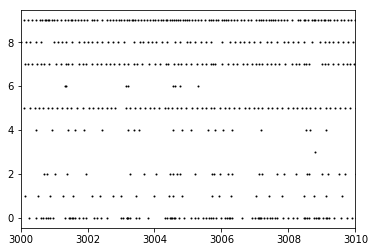

In [6]:
for i, spiketrain in enumerate(trains):
    plt.plot(spiketrain, i* np.ones_like(spiketrain), 'k.', markersize=2)
plt.xlim(3000, 3010)
plt.show()

In [7]:
cc_matrix = elephant.spike_train_correlation.corrcoef(BinnedSpikeTrain(trains, binsize=.6*s))

C:\ProgramData\Anaconda3\lib\site-packages\elephant\spike_train_correlation.py:213: RuntimeWarning:

overflow encountered in long_scalars



### Test for proportion of spikes from A falling within ±Δt of a spike from B by chance

In [44]:
def run_P(spiketrain_1, spiketrain_2, dt):
    N1 = len(spiketrain_1)
    N2 = len(spiketrain_2)
    Nab = 0
    j = 0
    for i in range(N1):
        while j < N2:  # don't need to search all j each iteration
            if np.abs(spiketrain_1[i] - spiketrain_2[j]) <= dt:
                Nab = Nab + 1
                break
            elif spiketrain_2[j] > spiketrain_1[i]:
                break
            else:
                j = j + 1
    return Nab

#### Make pairwise comparison of all neurons. Save the P values as a matrix

In [97]:
P_matrix = []
for train in trains.index:
    P_list = []
    index = 0
    print(train)
    while index < len(trains.index):
        P_values = run_P(spiketrain_1=trains.loc[train], spiketrain_2=trains.iloc[index], dt=0.005 * pq.s)/len(trains.loc[train])
        P_list.append(P_values)
        index=index+1
    P_matrix.append(P_list)

matrix_df = pd.DataFrame(P_matrix, columns=trains.index, index= trains.index)

20
22
24
33
57
79
82
123
128
129


[[1.0,
  0.01743926673966825,
  0.03086344648578497,
  0.07089264711846534,
  0.01995376566492274,
  0.04964107555663706,
  0.013829744088899703,
  0.0463965608143732,
  0.038325830392991846,
  0.12394046315447946],
 [0.07916053019145802,
  1.0,
  0.040316642120765835,
  0.0066273932253313695,
  0.023932253313696614,
  0.0741899852724595,
  0.016568483063328424,
  0.07271723122238587,
  0.05670103092783505,
  0.09628129602356407],
 [0.08350639414143622,
  0.023937042299704885,
  1.0,
  0.006230189091704011,
  0.03158815171056946,
  0.06732976281560826,
  0.025030057929828396,
  0.07334134878128758,
  0.05180894086785441,
  0.10318067548365942],
 [0.02174345953750031,
  0.000460508301595599,
  0.0007218778781768849,
  1.0,
  0.00037338510940183704,
  0.0020909566126502874,
  0.0005351853234759665,
  0.0014437557563537699,
  0.0014935404376073482,
  0.1285689393373659],
 [0.10490405117270789,
  0.02771855010660981,
  0.06098081023454158,
  0.0061833688699360345,
  1.0,
  0.06886993603411

#### Plot the matrix 

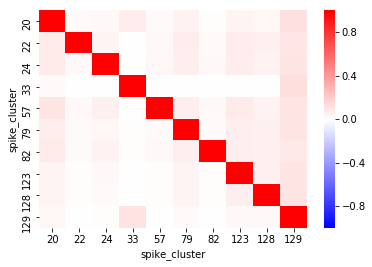

In [105]:
sns.heatmap(matrix_df, vmin=-1, vmax=1, cmap='bwr')

### Do the same thing as above, except splitting the trainlines into 2 periods: Baseline, and with drug (CIT)

In [113]:
t_start_base=min(data[data['condition']=='Baseline']['time'])
t_stop_base=max(data[data['condition']=='Baseline']['time'])
t_start_CIT=min(data[data['condition']=='CIT']['time'])
t_stop_CIT=max(data[data['condition']=='CIT']['time'])

In [115]:
baseline_trains = data[data['condition']=='Baseline'].groupby('spike_cluster')['time'].apply(neo.SpikeTrain, t_start=t_start_base*s, t_stop=t_stop_base*s, units=s)
CIT_trains = data[data['condition']=='CIT'].groupby('spike_cluster')['time'].apply(neo.SpikeTrain, t_start=t_start_CIT*s, t_stop=t_stop_CIT*s, units=s)

### Compare the baseline and CIT trainlines of neuron 20 to all the other neurons

In [123]:
Base_corr = []
CIT_corr = []

for train in trains.index:
    Base_corr.append(run_P(spiketrain_1=baseline_trains.loc[20], spiketrain_2=baseline_trains.loc[train], dt=0.005 * pq.s)/len(baseline_trains.loc[20]))
    CIT_corr.append(run_P(spiketrain_1=CIT_trains.loc[20], spiketrain_2=CIT_trains.loc[train], dt=0.005 * pq.s)/len(CIT_trains.loc[20]))

comparison_df = pd.DataFrame({'Base':Base_corr, 'CIT':CIT_corr}, index=trains.index)

#### Plot a bump chart to investigate if CIT can induce any change in correlation

(0, 0.2)

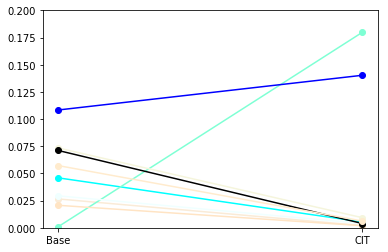

In [160]:
color = ['#F0F8FF', '#FAEBD7', '#00FFFF','#7FFFD4', '#F0FFFF','#F5F5DC', '#FFE4C4', '#000000', '#FFEBCD', '#0000FF']
for cluster in np.arange(0,10,1):
    plt.plot(comparison_df.iloc[cluster], marker='o', color=color[cluster])
    
plt.ylim(0, 0.2)

#### Test significance of correlation using spike_time_tiling_coefficient method

In [167]:
elephant.spike_train_correlation.spike_time_tiling_coefficient(CIT_trains.loc[20], CIT_trains.loc[129], dt=(0.005) * s)

0.014178486377405408

### Plots for instantaneous firing rate

In [16]:
Instant_Fr = []

for train in range(len(trains)):
    Instant_Fr.append(elephant.statistics.instantaneous_rate(trains.iloc[train], 10*s, kernel='auto', 
                                                        cutoff=5.0, t_start=t_start*s, t_stop=t_stop*s, trim=False))

C:\ProgramData\Anaconda3\lib\site-packages\elephant\statistics.py:817: UserWarning:

Instantaneous firing rate approximation contains negative values, possibly caused due to machine precision errors.



In [17]:
Instant_Fr = np.asarray(Instant_Fr)


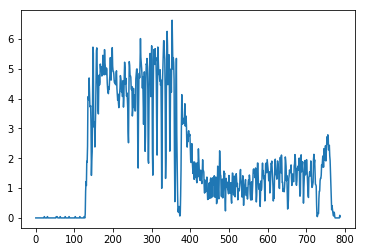

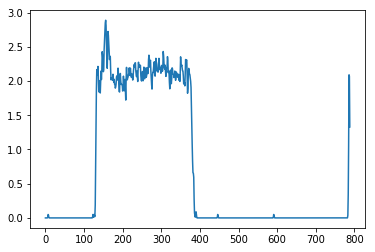

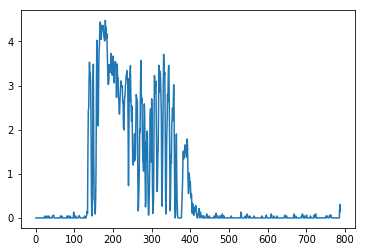

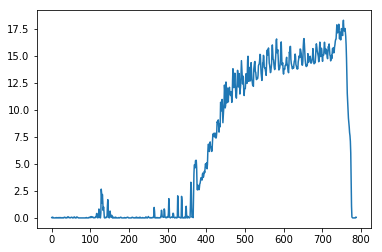

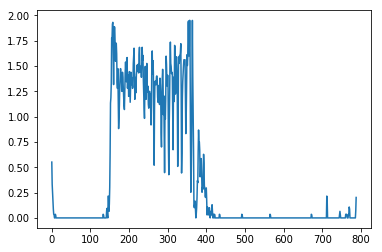

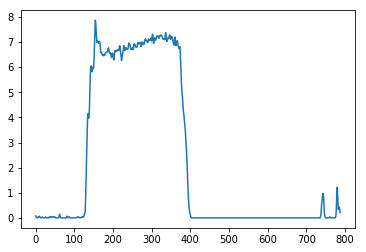

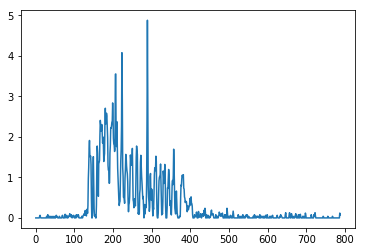

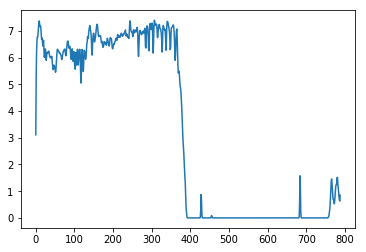

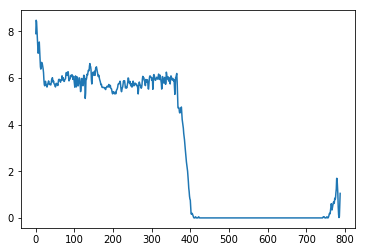

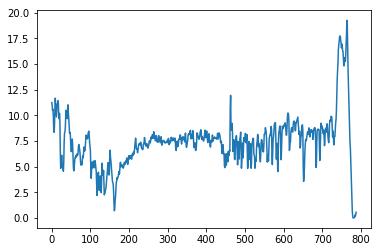

In [18]:
for indi_FR in Instant_Fr:
    plt.plot(indi_FR)
    plt.show()